# Caminhos:

#### Adicionar caminho: sys.path.append('/eos/user/t/thenriqu/Dark_Matter/LGBM_hhdm_analysis/')

#### Amostras: /eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets

#### Metadata: /eos/user/t/thenriqu/Dark_Matter/metadata.json

# Bibliotecas

In [1]:
import sys
sys.path.append('/eos/user/t/thenriqu/Dark_Matter/XGB_MLP_hhdm_analysis/')


import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import hepherolib.data as data
import hepherolib.analysis as ana

from sklearn.model_selection import train_test_split
from statsmodels.stats.weightstats import DescrStatsW
from mpl_toolkits.axes_grid1 import make_axes_locatable

from hhdm_analysis.utils import position
from hhdm_analysis.wcorr import pd_wcorr, cluster_corr

ana.start()
plt.style.use("default")

# Configuração

In [2]:
period = '17'
year_style = 2017
dataset_year = "2017"
basedir = '/eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets'
dataset_name = basedir.split('/')[-2]

# Setup output folders
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)



# Lendo Metadata

In [3]:
with open("/eos/user/t/thenriqu/Dark_Matter/metadata.json", "r") as f:
    metadata = json.load(f)

ST = metadata.get("datasets").get("ST")
TT = metadata.get("datasets").get("TT")
ZZ = metadata.get("datasets").get("ZZ")
WZ = metadata.get("datasets").get("WZ")
DY = metadata.get("datasets").get("DY")
RESIDUAL = metadata.get("datasets").get("RESIDUAL")
DATA = metadata.get("datasets").get("DATA")

# Lendo os dados

In [4]:
variables = ["RegionID", "evtWeight", "LeadingLep_pt", "LepLep_pt", "LepLep_deltaR", "LepLep_deltaM", "MET_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "TrailingLep_pt", "MT2LL", "Nbjets"]
ds = data.read_files(basedir, period, mode="normal", features=variables)
data.join_datasets(ds, "ST", ST.get(period), mode="normal")
data.join_datasets(ds, "TT", TT.get(period), mode="normal")
data.join_datasets(ds, "ZZ", ZZ.get(period), mode="normal")
data.join_datasets(ds, "WZ", WZ.get(period), mode="normal")
data.join_datasets(ds, "DYJetsToLL", DY.get(period), mode="normal")
data.join_datasets(ds, "Residual", RESIDUAL.get(period), mode="normal")

# Datasets to be used
used_datasets = ["Signal_400_100", "Signal_1000_100", "ST", "TT", "ZZ", "WZ", "DYJetsToLL", "Residual"]

for dt_name in used_datasets:
    print(dt_name, ds[dt_name].shape)

# Delete every other dataset
datasets_to_delete = [dt_name for dt_name in ds.keys() if dt_name not in used_datasets]
for dt_name in datasets_to_delete:
    del ds[dt_name]


Loading datasets...


100%|██████████| 73/73 [00:02<00:00, 28.63it/s]


Signal_400_100 (127644, 12)
Signal_1000_100 (183832, 12)
ST (74347, 12)
TT (1951619, 12)
ZZ (1400437, 12)
WZ (25638, 12)
DYJetsToLL (6003369, 12)
Residual (974059, 12)


# Pré-processamento dos Dados

In [5]:
# Filtering SR
ds = {k: v[v.RegionID == 0] for k,v in ds.items()}

# Selecting backgrounds and signals
model_name = "MLP_multi_signal"
signals_to_use = [key for key in ds.keys() if "Signal_" in key]
signals = [ds[key] for key in signals_to_use]
backgrounds = [ds["ST"], ds["TT"], ds["ZZ"], ds["WZ"], ds["DYJetsToLL"], ds["Residual"]]

# Labeling
for bkg in backgrounds:
    bkg.loc[:, "Label"] = 0
for signal in signals:
    signal.loc[:, "Label"] = 1

# Generate train and test data pre-processing weights
datasets = [*signals, pd.concat(backgrounds)]
train_dataset = []
test_dataset = []

for dataset in datasets:
    df_train, df_test = train_test_split(dataset, test_size=0.5, random_state=42)
    
    # Scale event weight by train/test split
    train_factor = dataset.evtWeight.sum() / df_train.evtWeight.sum()
    test_factor = dataset.evtWeight.sum() / df_test.evtWeight.sum()
    df_train["evtWeight"] = df_train.evtWeight * train_factor 
    df_test["evtWeight"] = df_test.evtWeight * test_factor
    
    # Normalize weights
    df_train["modelWeight"] = df_train.evtWeight / df_train.evtWeight.sum()
    df_test["modelWeight"] = df_test.evtWeight / df_test.evtWeight.sum()
    
    train_dataset.append(df_train)
    test_dataset.append(df_test)

# Group train and test
train_dataset = pd.concat(train_dataset)
test_dataset = pd.concat(test_dataset)

# Re-normalize
train_dataset["modelWeight"] = train_dataset.modelWeight / train_dataset.modelWeight.sum()
test_dataset["modelWeight"] = test_dataset.modelWeight / test_dataset.modelWeight.sum()

# Transform features to z-score using weighted mean and std from train dataset
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]
features_dict = {
    "LeadingLep_pt": r"leading lepton $p_{T}$ [GeV]",
    "LepLep_deltaM": r"$|M_{\ell \ell} - M_{Z}|$ [GeV]",
    "LepLep_deltaR": r"$\Delta R^{\ell \ell}$",
    "LepLep_pt": r"$p_{T}^{\ell \ell}$ [GeV]",
    "MET_LepLep_Mt": r"$M^{\ell \ell, MET}_{T}$ [GeV]",
    "MET_LepLep_deltaPhi": r"$\Delta \phi^{\ell \ell+MET}$",
    "MET_pt": r"MET $p_{T}$ [GeV]",
    "MT2LL": "MT2LL",
    "Nbjets": "Number of b-jets",
    "TrailingLep_pt": r"trailing lepton $p_{T}$ [GeV]"
}
zscore = {}

for feature in features:
    weighted_stats = DescrStatsW(train_dataset[feature].values, weights=train_dataset[feature].values, ddof=0)
    train_dataset[feature] = (train_dataset[feature] - weighted_stats.mean) / weighted_stats.std
    test_dataset[feature] = (test_dataset[feature] - weighted_stats.mean) / weighted_stats.std
    zscore[feature] = {"mean": weighted_stats.mean, "std": weighted_stats.std}

# Shuffle
train_dataset = train_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Plot da Distribuição

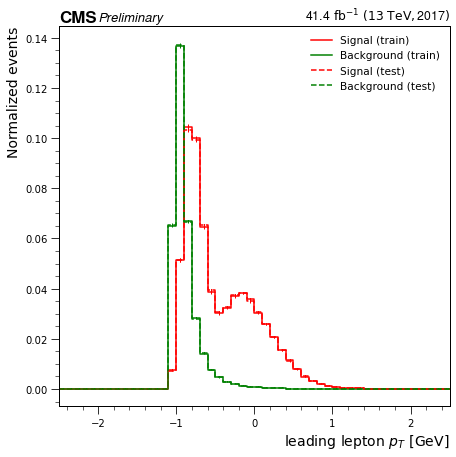

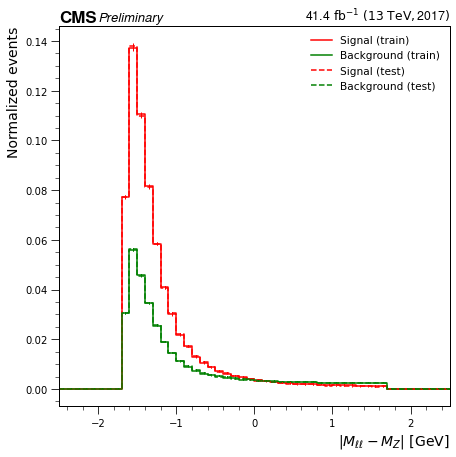

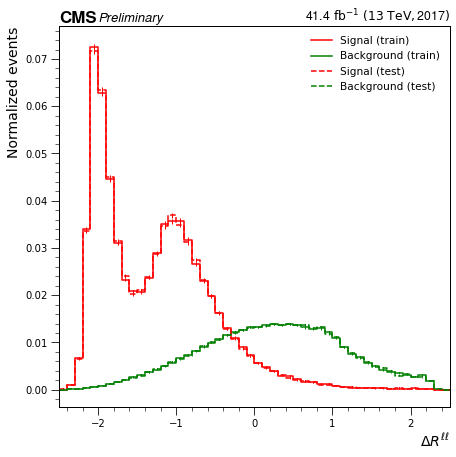

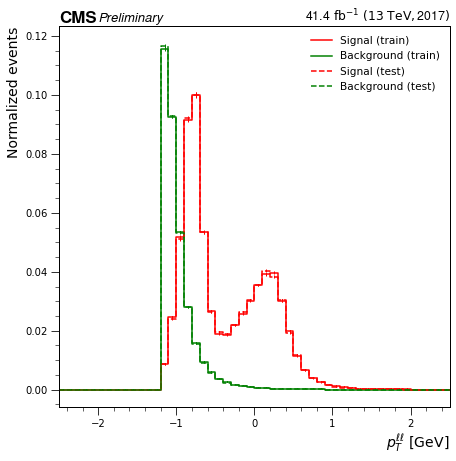

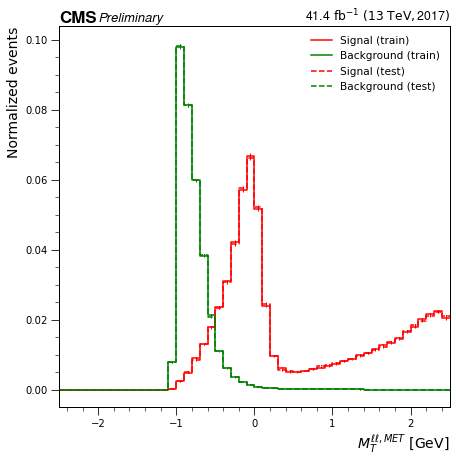

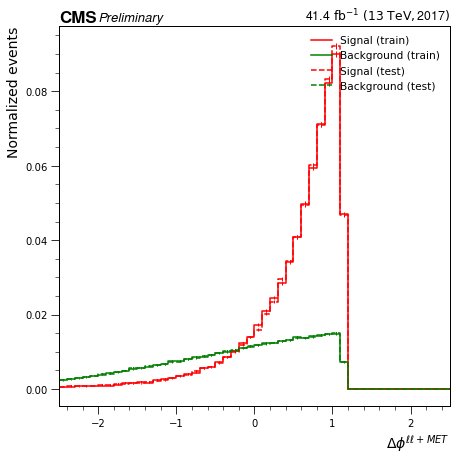

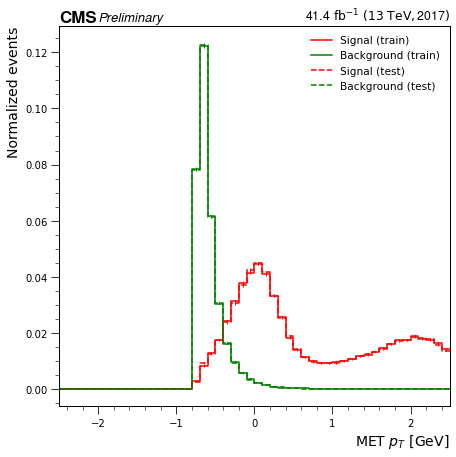

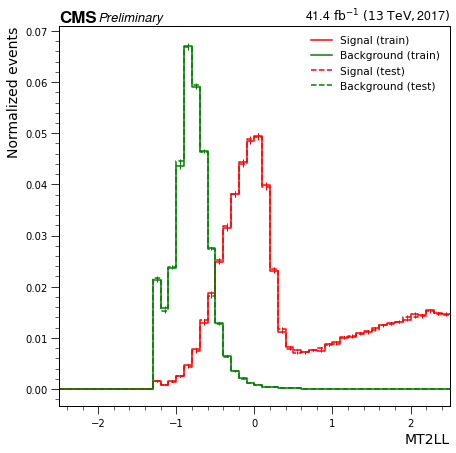

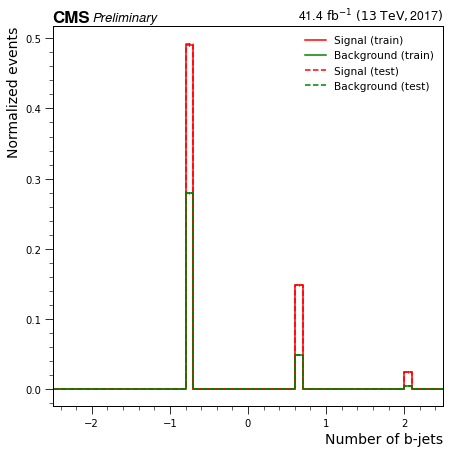

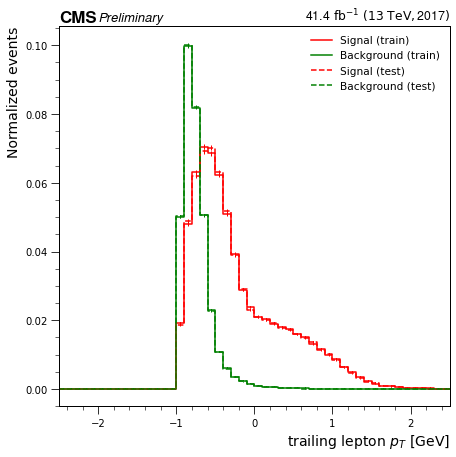

In [6]:
for feature in features:
    # Plot config
    fig = plt.figure(figsize=(7,7))
    grid = [1,1] # number of rows, number of cols
    gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

    # Plot code
    ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

    ana.step_plot(ax1, feature, train_dataset[train_dataset.Label == 1], label=f"Signal (train)", color="red", weight="modelWeight", bins=np.linspace(-2.5, 2.5, 51), error=True)
    ana.step_plot(ax1, feature, train_dataset[train_dataset.Label == 0], label=f"Background (train)", color="green", weight="modelWeight", bins=np.linspace(-2.5, 2.5, 51), error=True)
    ana.step_plot(ax1, feature, test_dataset[test_dataset.Label == 1], label=f"Signal (test)", color="red", weight="modelWeight", bins=np.linspace(-2.5, 2.5, 51), linestyle="--", error=True)
    ana.step_plot(ax1, feature, test_dataset[test_dataset.Label == 0], label=f"Background (test)", color="green", weight="modelWeight", bins=np.linspace(-2.5, 2.5, 51), linestyle="--", error=True)
    
    ana.labels(ax1, ylabel="Normalized events", xlabel=features_dict[feature])
    ana.style(
        ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
        ylog=False, legend_ncol=1,
    )
    plt.savefig(f"{figures_path}/preprocessed-{feature}.png", dpi=200, facecolor='white')
    plt.show()
    plt.close()

# Plot da Matriz de Correção

In [7]:
# Pandas dataframe corr() method doesn't consider weights, thats why we implemented this

train_corr = cluster_corr(pd_wcorr(df=train_dataset[features], weights=train_dataset.evtWeight, rmv_neg_weights=True))
test_corr = cluster_corr(pd_wcorr(df=test_dataset[features], weights=test_dataset.evtWeight, rmv_neg_weights=True))

## Dataset de Treino

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


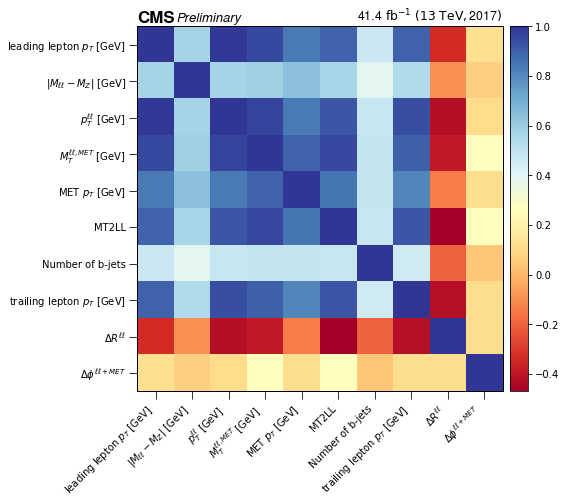

In [8]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
im = ax.imshow(train_corr, cmap="RdYlBu")
fig.colorbar(im, cax=cax, orientation="vertical")

ana.style(
    ax, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=1,
)
ax.set_yticks(np.arange(len(features)))
ax.set_xticks(np.arange(len(features)))
ax.set_yticklabels([features_dict[col] for col in train_corr.columns], size=10)
ax.set_xticklabels([features_dict[idx] for idx in train_corr.index], size=10, rotation=45, ha="right")
ax.minorticks_off()

plt.savefig(f"{figures_path}/correlation_matrix_train.png", dpi=200, facecolor='white', bbox_inches = "tight")
plt.show()
plt.close()

## Dataset de Teste

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


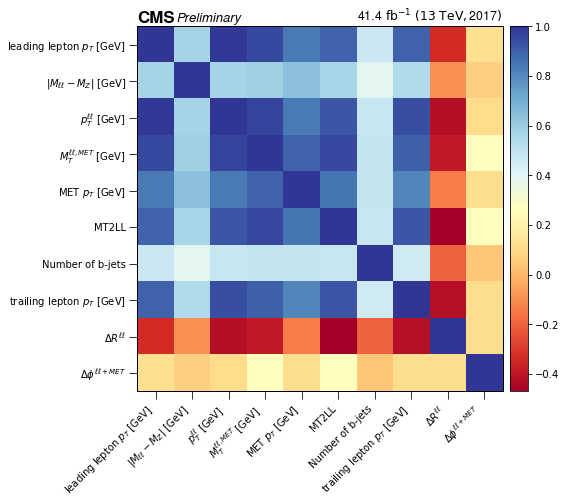

In [9]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
im = ax.imshow(train_corr, cmap="RdYlBu")
fig.colorbar(im, cax=cax, orientation="vertical")

ana.style(
    ax, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=1,
)
ax.set_yticks(np.arange(len(features)))
ax.set_xticks(np.arange(len(features)))
ax.set_yticklabels([features_dict[col] for col in test_corr.columns], size=10)
ax.set_xticklabels([features_dict[idx] for idx in test_corr.index], size=10, rotation=45, ha="right")
ax.minorticks_off()

plt.savefig(f"{figures_path}/correlation_matrix_test.png", dpi=200, facecolor='white', bbox_inches = "tight")
plt.show()
plt.close()

# Salvar os dados processados

In [10]:
# Pop unused variables at this point
train_dataset.pop("RegionID")
test_dataset.pop("RegionID")

train_dataset.to_csv(f"{data_path}/{model_name}-train-data.csv", index=False)
test_dataset.to_csv(f"{data_path}/{model_name}-test-data.csv", index=False)

with open(f"{data_path}/{model_name}-weighted_stats.json", "w") as f:
    json.dump(zscore, f, ensure_ascii=False, indent=4)